In [1]:
from image_explainer import *
from utils import *
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import pandas as pd
import torch
import torchvision
from sklearn.manifold import TSNE
from modules import *
import random

In [2]:
embeds = load_inception_embeds()

X_train = torch.tensor(embeds["X_train"])
Y_train = torch.tensor(embeds["Y_train"])

X_test = torch.tensor(embeds["X_test"])
Y_test = torch.tensor(embeds["Y_test"])

# rule#1:
# Y_train[:100]=torch.tensor(0)
# for i in X_train[:100]:
#     i[:500]=torch.tensor(0)
#     i[-500:]=torch.tensor(0)

# X_test[200][:500]=torch.tensor(0)
# X_test[200][-500:]=torch.tensor(0)
# Y_test[200]=torch.tensor(0)
# Y_test[300] = torch.tensor([0.])
# Y_test[458] = torch.tensor([0.])
train_set = data.TensorDataset(X_train, Y_train)
test_set = data.TensorDataset(X_test, Y_test)
clf = fit_model(X_train, Y_train)

Using cached Inceptionv3 embeddings: /user/cs.aau.dk/em63by/Influence_Function_Evaluation/Projects/data/dataset_coda.npz


In [3]:
# test_idx = 300
# testsimilarity=[cosine_similarity(X_test[test_idx].numpy().reshape(1,-1), X_test[i].numpy().reshape(1, -1)).item()
#                for i in range(len(X_test))]

In [4]:
module = LiSSAInfluenceModule(
    model=clf,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)
train_idxs = list(range(X_train.shape[0]))

In [5]:
# image = captioned_image(clf, embeds, 'test', 73)
# plt.imshow(image)
# plt.axis('off')
# plt.show()

In [6]:
# Build a dataframe with X-trains with threir corresponding influence scores and similarity
def df_construct(test_idx, train_idxs):
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    
    similarity=[cosine_similarity(X_test[test_idx].numpy().reshape(1,-1), X_train[i].numpy().reshape(1, -1)).item()
               for i in range(len(X_train))]
    squared_diff = (clf(X_train.to(DEVICE)) - Y_train.to(DEVICE))**2

    # Calculate the RMS error for each training point
    train_losses = torch.sqrt(squared_diff)

    # Detach the tensor from the computation graph
    train_losses = train_losses.detach().requires_grad_(False)
    relatif=influences/train_losses

    data = {'Influence': influences.reshape(-1).tolist(), "Relatif":relatif, 'Similarity': similarity, 'Y_train':Y_train.tolist(), 
            'X_train':X_train.numpy().tolist()}
    df = pd.DataFrame(data)
    return df

# test_idx = 200
# df = df_construct(test_idx, train_idxs)

In [ ]:
df_pos_sl, df_pos_ol = input_data(df, test_idx, Y_test, sett='positive')
df_neg_ol, df_neg_sl = input_data(df, test_idx, Y_test, sett='negative')
selected_indices_pos_sl = greedy_subset_selection(df_pos_sl, N=3, sett='positive', label='same')
selected_indices_pos_ol = greedy_subset_selection(df_pos_ol, N=3, sett='positive', label='opposite')
selected_indices_neg_sl = greedy_subset_selection(df_neg_sl, N=3, sett='negative', label='same')
selected_indices_neg_ol = greedy_subset_selection(df_neg_ol, N=3, sett='negative', label='opposite')


In [ ]:
 def draw(test_indx, train_idxs): 
    # ===========
    # Plot image
    # =========
    new_line = '\n'
    fig, axs = plt.subplots(2, 3, figsize=(8.5, 6))
    
    for i, j in enumerate((-train_idxs).argsort()[:6]):
        if i<3:
            axs[0, i].imshow(captioned_image(clf, embeds, 'train', j)) 
            axs[0, i].text(0.5, -0.1, "Dog", size=14, ha="center", transform=axs[0, i].transAxes)
            axs[0, i].axis('off')
        else:
            axs[1, i-3].imshow(captioned_image(clf, embeds, 'train', j)) 
            axs[1, i-3].text(0.5, -0.1, "Dog", size=14, ha="center", transform=axs[1, i-3].transAxes)
            axs[1, i-3].axis('off')
        
#     for i, j in enumerate(train_idxs.argsort()[:6]):
#         axs[2, i].imshow(captioned_image(clf, embeds, 'train', j))
#         axs[2, i].axis('off')
#         axs[2, i].text(0.5, -0.15, f"Influence: {train_idxs[j]:.8f} {new_line} Label: {Y_train[j.item()].item()}", size=10, ha="center", transform=axs[2, i].transAxes)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
#     plt.savefig(f'inf_{test_indx}.svg', format='svg', bbox_inches="tight")
    plt.show() 
    
draw(test_idx,np.array(df.Influence.tolist()))

In [ ]:
 def draw(test_indx, train_idxs): 
    # ===========
    # Plot image
    # =========
    new_line = '\n'
    fig, axs = plt.subplots(2, 3, figsize=(8.5, 6))
    
    for i, j in enumerate(train_idxs[:6]):
        if i<3:
            axs[0, i].imshow(captioned_image(clf, embeds, 'train', j)) 
            axs[0, i].text(0.5, -0.1, "Dog", size=14, ha="center", transform=axs[0, i].transAxes)
            axs[0, i].axis('off')
        else:
            axs[1, i-3].imshow(captioned_image(clf, embeds, 'train', j)) 
            axs[1, i-3].text(0.5, -0.1, "Dog", size=14, ha="center", transform=axs[1, i-3].transAxes)
            axs[1, i-3].axis('off')
        
#     for i, j in enumerate(train_idxs.argsort()[:6]):
#         axs[2, i].imshow(captioned_image(clf, embeds, 'train', j))
#         axs[2, i].axis('off')
#         axs[2, i].text(0.5, -0.15, f"Influence: {train_idxs[j]:.8f} {new_line} Label: {Y_train[j.item()].item()}", size=10, ha="center", transform=axs[2, i].transAxes)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
#     plt.savefig(f'relatif_{test_indx}.svg', format='svg', bbox_inches="tight")
    plt.show() 
    
draw(test_idx,df.sort_values("Influence", ascending=False)[:54].sort_values("Relatif", ascending=False).index)

In [ ]:
plt.imshow(captioned_image(clf, embeds, 'test', 8))

In [ ]:
def print_result(test_idx, selected_indices_neg_ol=None, selected_indices_neg_sl=None,
                 selected_indices_pos_sl=None, selected_indices_pos_ol=None,
                 df_neg_ol=None, df_neg_sl=None,
                 df_pos_sl=None, df_pos_ol=None): 
    
    new_line = '\n'
    fig, axs = plt.subplots(2, 3, figsize=(8.5, 6))
    
    for i, j in enumerate(selected_indices_pos_sl):
        axs[0, i].imshow(captioned_image(clf, embeds, 'train', df_pos_sl.Influence.index[j])) 
#         axs[0, i].text(0.5, -0.1, "Dog", size=14, ha="center", transform=axs[0, i].transAxes)
        axs[0, i].axis('off')

    for i, j in enumerate(selected_indices_pos_ol):
        axs[1, i].imshow(captioned_image(clf, embeds, 'train', df_pos_ol.Influence.index[j])) 
#         axs[1, i].text(0.5, -0.1, "Fish", size=14, ha="center", transform=axs[1, i].transAxes)
        axs[1, i].axis('off')    
        
#     for i, j in enumerate(selected_indices_neg_ol):
#         axs[2, i].imshow(captioned_image(clf, embeds, 'train', df_neg_ol.Influence.index[j])) 
# #         axs[2, i].text(0.5, -0.1, "Fish", size=14, ha="center", transform=axs[2, i].transAxes)
#         axs[2, i].axis('off')

#     for i, j in enumerate(selected_indices_neg_sl):
#         axs[3, i].imshow(captioned_image(clf, embeds, 'train', df_neg_sl.Influence.index[j])) 
# #         axs[3, i].text(0.5, -0.1, "Dog", size=14, ha="center", transform=axs[3, i].transAxes)
#         axs[3, i].axis('off')           
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
#     plt.savefig(f'ibd_{test_idx}.svg', format='svg', bbox_inches="tight")

    plt.show() 
    
    
    
print_result(test_idx, selected_indices_neg_ol=selected_indices_neg_ol, selected_indices_neg_sl=selected_indices_neg_sl,
                 selected_indices_pos_sl=selected_indices_pos_sl, selected_indices_pos_ol=selected_indices_pos_ol,
                 df_neg_ol=df_neg_ol, df_neg_sl=df_neg_sl,
                 df_pos_sl=df_pos_sl, df_pos_ol=df_pos_ol)

In [ ]:
 def draw(test_indx, train_idxs): 
    # ===========
    # Plot image
    # =========
    new_line = '\n'
    fig, axs = plt.subplots(3, 3, figsize=(11, 11))
    axs[0, 0].imshow(captioned_image(clf, embeds, 'test', test_indx))
    axs[0, 0].axis('off')
    axs[0, 0].text(0.5, -0.15, f"Prediction: {clf(X_test[test_indx].unsqueeze(0)).round().item()} {new_line} Actual Label: {Y_test[test_indx].item()}", size=14, ha="center", transform=axs[0, 0].transAxes)
    axs[1, 0].text(-0.1, 0, 'Influential Samples',size=14, rotation=90, va='center', ha='right', transform=axs[1, 0].transAxes)
    axs[0, 0].set_title('Test Prediction',size=14)
    
    for i, j in enumerate((-train_idxs).argsort()[:6]):
        if i<3:
            axs[1, i].imshow(captioned_image(clf, embeds, 'train', j)) 
            axs[1, i].text(0.5, -0.1, f"Label: {Y_train[j.item()].item()}", size=14, ha="center", transform=axs[1, i].transAxes)
            axs[1, i].axis('off')
            axs[0, i].axis('off')
        else:
            axs[2, i-3].imshow(captioned_image(clf, embeds, 'train', j)) 
            axs[2, i-3].text(0.5, -0.1, f"Label: {Y_train[j.item()].item()}", size=14, ha="center", transform=axs[2, i-3].transAxes)
            axs[2, i-3].axis('off')
            axs[0, i-3].axis('off')
        
#     for i, j in enumerate(train_idxs.argsort()[:6]):
#         axs[2, i].imshow(captioned_image(clf, embeds, 'train', j))
#         axs[2, i].axis('off')
#         axs[2, i].text(0.5, -0.15, f"Influence: {train_idxs[j]:.8f} {new_line} Label: {Y_train[j.item()].item()}", size=10, ha="center", transform=axs[2, i].transAxes)

#     plt.savefig(f'inf_{test_indx}.eps', format='eps', bbox_inches="tight")

    plt.show() 
draw(test_idx,np.array(df.Influence.tolist()))

In [ ]:
selected_indices_pos_ol

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def get_explanation(i):
    
        df = df_construct(i, train_idxs)
        df_pos_sl, df_pos_ol = input_data(df, i, Y_test, sett='positive')
        df_neg_ol, df_neg_sl = input_data(df, i, Y_test, sett='negative')
        selected_indices_pos_sl = greedy_subset_selection(df_pos_sl, N=5, sett='positive', label='same')
        selected_indices_pos_ol = greedy_subset_selection(df_pos_ol, N=5, sett='positive', label='opposite')
        selected_indices_neg_sl = greedy_subset_selection(df_neg_sl, N=5, sett='negative', label='same')
        selected_indices_neg_ol = greedy_subset_selection(df_neg_ol, N=5, sett='negative', label='opposite')
        a=[df_pos_sl.Influence.index[k] for k in selected_indices_pos_sl]
        b=[df_neg_ol.Influence.index[k] for k in selected_indices_neg_ol]
        c=[df_neg_sl.Influence.index[k] for k in selected_indices_neg_sl]
        d=[df_pos_ol.Influence.index[k] for k in selected_indices_pos_ol]
        return a+b

from scipy.optimize import linear_sum_assignment

def find_best_matches(embeddings_list1, embeddings_list2):
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings_list1, embeddings_list2)

    # Use the Hungarian algorithm to find the optimal assignment
    row_indices, col_indices = linear_sum_assignment(-similarity_matrix)

    # Extract the pairs of best matches and their corresponding similarity scores
    best_matches = [(row_indices[i], col_indices[i]) for i in range(len(row_indices))]
    similarity_scores = [-similarity_matrix[row][col] for row, col in best_matches]

    return best_matches, similarity_scores

def average_mbm_similarity(embeddings_list1, embeddings_list2):
    # Find the best matches and their similarity scores
    best_matches, similarity_scores = find_best_matches(embeddings_list1, embeddings_list2)

    # Compute the average cosine similarity using the similarity scores
    avg_similarity = np.mean(np.abs(similarity_scores))
    
    return avg_similarity
    
    
def aide_eval(test_idx):
    simlist=np.array([cosine_similarity(X_test[test_idx].numpy().reshape(1,-1), X_test[i].numpy().reshape(1, -1)).item()
               for i in range(len(X_test))])
    mostsim=simlist.argsort()[-5:]
    leastsim=simlist.argsort()[:5]
    concatenated_array = np.concatenate((mostsim, leastsim)).tolist()
    set1=get_explanation(test_idx)
    print(f'set1 for {test_idx},  {set1}')
#     mbm_sim=[]
    carray=[]
    fuzzy_jac=[]
    for i in tqdm(concatenated_array):
        influences = module.influences(train_idxs=train_idxs, test_idxs=[i])
        if np.count_nonzero(influences)>800:
            set2=get_explanation(i)
            print(f'from set2 =>{i} = > explanation {set2}')
#             jac_sim.append(jaccard_similarity(set(set1), set(set2)))
            similarity_matrix = cosine_similarity(X_train[[set1]], X_train[[set2]])
            mbm=average_mbm_similarity(X_train[[set1]], X_train[[set2]])
#             mbm_sim.append(mbm)
            fuzzy_jac.append(mbm/(len(set2)/5 - mbm))
            carray.append(i)
        else:
            continue
    cosine_sim=simlist[[carray]]
    return cosine_sim.flatten().tolist(), fuzzy_jac
        

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

set1 for 454,  [1454, 1195, 1308, 1131, 1443, 922, 1141, 1589, 1713, 797]



 10%|██████▍                                                         | 1/10 [00:12<01:52, 12.48s/it]

from set2 =>422 = > explanation [1447, 725, 1131, 254, 761, 313, 1141, 1589, 797, 1713]



 20%|████████████▊                                                   | 2/10 [00:24<01:39, 12.48s/it]

from set2 =>107 = > explanation [45, 725, 249, 1488, 254, 682, 1141, 1589, 1446, 1437]



 30%|███████████████████▏                                            | 3/10 [00:37<01:27, 12.46s/it]

from set2 =>546 = > explanation [1454, 1131, 1195, 725, 1443, 1261, 1141, 797, 1713, 658]



 40%|█████████████████████████▌                                      | 4/10 [00:49<01:14, 12.48s/it]

from set2 =>338 = > explanation [1131, 1195, 1443, 907, 725, 200, 1141, 1654, 797, 1713]



 50%|████████████████████████████████                                | 5/10 [01:02<01:02, 12.47s/it]

from set2 =>454 = > explanation [1454, 1195, 1308, 1131, 1443, 1004, 1141, 1589, 1713, 797]



 60%|██████████████████████████████████████▍                         | 6/10 [01:14<00:49, 12.48s/it]

from set2 =>423 = > explanation [1080, 1416, 1576, 1570, 906, 71, 45, 1447, 1744, 93]



 70%|████████████████████████████████████████████▊                   | 7/10 [01:27<00:37, 12.48s/it]

from set2 =>161 = > explanation [593, 1679, 461, 339, 626, 1215, 971, 526, 1447, 1269]



 80%|███████████████████████████████████████████████████▏            | 8/10 [01:39<00:24, 12.47s/it]

from set2 =>529 = > explanation [1084, 500, 416, 1611, 912, 1470, 1153, 302, 1496, 71]



 90%|█████████████████████████████████████████████████████████▌      | 9/10 [01:52<00:12, 12.47s/it]

from set2 =>187 = > explanation [871, 868, 390, 632, 591, 316, 984, 219, 1459, 64]



 10%|██████▎                                                        | 1/10 [02:17<20:37, 137.46s/it]

from set2 =>532 = > explanation [1141, 1679, 461, 339, 626, 1470, 971, 1097, 1447, 821]
set1 for 317,  [1447, 689, 1488, 1220, 928, 1239, 1141, 1589, 208, 1134]



 10%|██████▍                                                         | 1/10 [00:12<01:52, 12.46s/it]

from set2 =>290 = > explanation [1447, 282, 365, 725, 738, 1726, 1141, 1589, 1437, 1654]



 20%|████████████▊                                                   | 2/10 [00:24<01:39, 12.47s/it]

from set2 =>94 = > explanation [509, 1488, 689, 725, 1764, 162, 1141, 1589, 1437, 1436]



 30%|███████████████████▏                                            | 3/10 [00:37<01:27, 12.47s/it]

from set2 =>592 = > explanation [761, 509, 689, 1764, 1488, 219, 1141, 1589, 1446, 1437]



 40%|█████████████████████████▌                                      | 4/10 [00:49<01:14, 12.49s/it]

from set2 =>213 = > explanation [1603, 1488, 689, 725, 1751, 489, 1141, 1589, 1436, 1624]



 50%|████████████████████████████████                                | 5/10 [01:02<01:02, 12.48s/it]

from set2 =>317 = > explanation [1447, 689, 1488, 1220, 928, 1679, 1141, 1589, 208, 1134]



 60%|██████████████████████████████████████▍                         | 6/10 [01:14<00:49, 12.47s/it]

from set2 =>161 = > explanation [593, 1679, 461, 339, 626, 1470, 971, 526, 1447, 1269]



 70%|████████████████████████████████████████████▊                   | 7/10 [01:27<00:37, 12.48s/it]

from set2 =>532 = > explanation [1141, 1679, 461, 339, 593, 1342, 971, 1447, 1097, 821]



 80%|███████████████████████████████████████████████████▏            | 8/10 [01:39<00:24, 12.47s/it]

from set2 =>423 = > explanation [1080, 1416, 1576, 1570, 906, 1222, 45, 1447, 1744, 93]



 90%|█████████████████████████████████████████████████████████▌      | 9/10 [01:52<00:12, 12.48s/it]

from set2 =>325 = > explanation [687, 149, 1173, 1126, 839, 1226, 1193, 373, 610, 1064]



 20%|████████████▌                                                  | 2/10 [04:34<18:19, 137.45s/it]

from set2 =>352 = > explanation [984, 64, 1125, 1053, 576, 297, 390, 197, 868, 632]
set1 for 274,  [687, 303, 344, 1205, 680, 1456, 1512, 802, 823, 1513]



 10%|██████▍                                                         | 1/10 [00:12<01:52, 12.46s/it]

from set2 =>4 = > explanation [1141, 1272, 626, 149, 955, 1312, 1447, 975, 823, 802]



 20%|████████████▊                                                   | 2/10 [00:24<01:39, 12.46s/it]

from set2 =>591 = > explanation [687, 626, 680, 1272, 344, 1389, 1447, 60, 823, 802]



 30%|███████████████████▏                                            | 3/10 [00:37<01:27, 12.46s/it]

from set2 =>192 = > explanation [593, 1272, 344, 680, 626, 388, 1447, 802, 395, 429]



 40%|█████████████████████████▌                                      | 4/10 [00:49<01:14, 12.46s/it]

from set2 =>61 = > explanation [687, 118, 626, 1173, 593, 191, 1447, 802, 824, 786]



 50%|████████████████████████████████                                | 5/10 [01:02<01:02, 12.46s/it]

from set2 =>274 = > explanation [687, 303, 344, 1205, 680, 1552, 802, 823, 1512, 1513]



 60%|██████████████████████████████████████▍                         | 6/10 [01:14<00:49, 12.46s/it]

from set2 =>529 = > explanation [1084, 500, 416, 1611, 912, 59, 1153, 302, 1496, 71]



 70%|████████████████████████████████████████████▊                   | 7/10 [01:27<00:37, 12.46s/it]

from set2 =>220 = > explanation [1141, 713, 2, 1230, 505, 1030, 1453, 1603, 1447, 243]



 80%|███████████████████████████████████████████████████▏            | 8/10 [01:39<00:24, 12.46s/it]

from set2 =>187 = > explanation [871, 868, 390, 632, 591, 554, 984, 219, 1459, 64]



 90%|█████████████████████████████████████████████████████████▌      | 9/10 [01:52<00:12, 12.46s/it]

from set2 =>234 = > explanation [984, 64, 1459, 267, 1053, 1312, 390, 197, 871, 632]



 30%|██████████████████▉                                            | 3/10 [06:52<16:01, 137.34s/it]

from set2 =>36 = > explanation [1141, 2, 497, 505, 910, 702, 1447, 158, 1603, 65]
set1 for 440,  [1141, 728, 70, 1065, 363, 1674, 1454, 140, 725, 1574]



 20%|████████████▊                                                   | 2/10 [00:18<01:17,  9.63s/it]

from set2 =>292 = > explanation [316, 1756, 1530, 1045, 427, 1131, 140, 616, 35, 725]



 30%|███████████████████▏                                            | 3/10 [00:30<01:16, 10.93s/it]

from set2 =>122 = > explanation [1589, 1451, 1302, 1065, 1392, 1769, 1454, 150, 1560, 1312]



 40%|█████████████████████████▌                                      | 4/10 [00:43<01:09, 11.54s/it]

from set2 =>205 = > explanation [1134, 4, 1065, 1325, 728, 390, 1454, 1013, 686, 47]



 50%|████████████████████████████████                                | 5/10 [00:55<00:59, 11.88s/it]

from set2 =>440 = > explanation [1141, 728, 70, 1065, 363, 1674, 1454, 140, 725, 1574]



 60%|██████████████████████████████████████▍                         | 6/10 [01:07<00:48, 12.08s/it]

from set2 =>423 = > explanation [1080, 1416, 1576, 1570, 906, 508, 45, 1447, 1744, 93]



 70%|████████████████████████████████████████████▊                   | 7/10 [01:20<00:36, 12.22s/it]

from set2 =>161 = > explanation [593, 1679, 461, 339, 626, 161, 971, 526, 1269, 1466]



 80%|███████████████████████████████████████████████████▏            | 8/10 [01:32<00:24, 12.30s/it]

from set2 =>325 = > explanation [687, 149, 1173, 1126, 839, 272, 1193, 373, 610, 1064]



 90%|█████████████████████████████████████████████████████████▌      | 9/10 [01:45<00:12, 12.34s/it]

from set2 =>529 = > explanation [1084, 500, 416, 1611, 912, 59, 1153, 302, 1496, 71]



 40%|█████████████████████████▏                                     | 4/10 [09:02<13:27, 134.62s/it]

from set2 =>567 = > explanation [1141, 1416, 1576, 1570, 906, 508, 45, 1447, 93, 1057]
set1 for 548,  [761, 895, 509, 725, 738, 910, 1141, 1589, 957, 1159]



 10%|██████▍                                                         | 1/10 [00:12<01:52, 12.52s/it]

from set2 =>244 = > explanation [1306, 1186, 882, 1399, 747, 1230, 1141, 1589, 952, 957]



 20%|████████████▊                                                   | 2/10 [00:24<01:39, 12.49s/it]

from set2 =>194 = > explanation [1507, 1186, 725, 1615, 88, 1679, 1141, 957, 1589, 1522]



 30%|███████████████████▏                                            | 3/10 [00:37<01:27, 12.48s/it]

from set2 =>544 = > explanation [761, 509, 247, 1764, 301, 1249, 1141, 1589, 957, 1159]



 40%|█████████████████████████▌                                      | 4/10 [00:49<01:14, 12.48s/it]

from set2 =>401 = > explanation [1454, 761, 738, 158, 725, 1618, 1141, 957, 1589, 1632]



 50%|████████████████████████████████                                | 5/10 [01:02<01:02, 12.47s/it]

from set2 =>548 = > explanation [761, 895, 509, 725, 738, 1239, 1141, 1589, 957, 1159]



 60%|██████████████████████████████████████▍                         | 6/10 [01:14<00:49, 12.48s/it]

from set2 =>161 = > explanation [593, 1679, 461, 339, 626, 864, 971, 1447, 526, 1269]



 70%|████████████████████████████████████████████▊                   | 7/10 [01:27<00:37, 12.47s/it]

from set2 =>532 = > explanation [1141, 1679, 461, 339, 593, 1470, 971, 1097, 1447, 821]



 80%|███████████████████████████████████████████████████▏            | 8/10 [01:39<00:24, 12.49s/it]

from set2 =>529 = > explanation [1084, 500, 416, 1611, 912, 861, 1153, 302, 1496, 71]



 90%|█████████████████████████████████████████████████████████▌      | 9/10 [01:52<00:12, 12.50s/it]

from set2 =>423 = > explanation [1080, 1416, 1576, 1570, 906, 508, 45, 1447, 1744, 93]



 50%|███████████████████████████████▌                               | 5/10 [11:20<11:18, 135.67s/it]

from set2 =>555 = > explanation [1507, 59, 636, 635, 18, 1437, 1080, 1624, 1134, 1625]
set1 for 521,  [1589, 1713, 363, 1261, 1141, 294, 191, 1714, 366, 1507]



 10%|██████▍                                                         | 1/10 [00:12<01:52, 12.46s/it]

from set2 =>63 = > explanation [1141, 593, 1713, 1261, 1256, 1630, 1447, 1454, 156, 306]



 20%|████████████▊                                                   | 2/10 [00:24<01:39, 12.48s/it]

from set2 =>453 = > explanation [1193, 1354, 895, 1104, 1488, 1693, 1589, 1713, 1310, 515]



 40%|█████████████████████████▌                                      | 4/10 [00:42<01:03, 10.56s/it]

from set2 =>9 = > explanation [1447, 738, 1295, 761, 725, 500, 1589, 533, 1625, 1141]



 50%|████████████████████████████████                                | 5/10 [00:55<00:56, 11.25s/it]

from set2 =>521 = > explanation [1589, 1713, 363, 1261, 1236, 771, 191, 1714, 366, 479]



 60%|██████████████████████████████████████▍                         | 6/10 [01:07<00:46, 11.68s/it]

from set2 =>423 = > explanation [1080, 1416, 1576, 1570, 906, 508, 45, 1447, 1744, 93]



 70%|████████████████████████████████████████████▊                   | 7/10 [01:20<00:35, 11.96s/it]

from set2 =>161 = > explanation [593, 1679, 461, 339, 626, 1535, 971, 526, 1447, 1269]



 80%|███████████████████████████████████████████████████▏            | 8/10 [01:32<00:24, 12.12s/it]

from set2 =>532 = > explanation [1141, 1679, 461, 339, 626, 1470, 971, 1097, 821, 1447]



 90%|█████████████████████████████████████████████████████████▌      | 9/10 [01:45<00:12, 12.23s/it]

from set2 =>567 = > explanation [1141, 1416, 1576, 1570, 906, 44, 45, 1447, 93, 1057]



 60%|█████████████████████████████████████▊                         | 6/10 [13:30<08:55, 133.96s/it]

from set2 =>529 = > explanation [1084, 500, 416, 1611, 912, 294, 1153, 302, 1496, 71]
set1 for 393,  [1097, 1399, 94, 388, 486, 398, 1141, 1436, 957, 1625]



 10%|██████▍                                                         | 1/10 [00:12<01:52, 12.47s/it]

from set2 =>563 = > explanation [1751, 1399, 1186, 486, 882, 1144, 1141, 483, 1081, 1004]



 20%|████████████▊                                                   | 2/10 [00:24<01:39, 12.48s/it]

from set2 =>371 = > explanation [1306, 1399, 789, 94, 1751, 135, 1141, 1589, 1446, 808]



 30%|███████████████████▏                                            | 3/10 [00:37<01:27, 12.49s/it]

from set2 =>194 = > explanation [1507, 1186, 1615, 725, 88, 1277, 1141, 1589, 957, 1522]



 40%|█████████████████████████▌                                      | 4/10 [00:49<01:14, 12.48s/it]

from set2 =>442 = > explanation [158, 314, 1074, 804, 1399, 667, 1141, 1589, 1625, 208]



 50%|████████████████████████████████                                | 5/10 [01:02<01:02, 12.48s/it]

from set2 =>393 = > explanation [1097, 1399, 94, 388, 486, 398, 1141, 1436, 957, 1625]



 60%|██████████████████████████████████████▍                         | 6/10 [01:14<00:49, 12.48s/it]

from set2 =>161 = > explanation [593, 1679, 461, 339, 626, 1389, 971, 526, 1447, 1269]



 70%|████████████████████████████████████████████▊                   | 7/10 [01:27<00:37, 12.48s/it]

from set2 =>423 = > explanation [1080, 1416, 1576, 1570, 906, 255, 45, 1447, 1744, 93]



 80%|███████████████████████████████████████████████████▏            | 8/10 [01:39<00:24, 12.48s/it]

from set2 =>529 = > explanation [1084, 500, 416, 1611, 912, 1342, 1153, 302, 1496, 71]



 90%|█████████████████████████████████████████████████████████▌      | 9/10 [01:52<00:12, 12.49s/it]

from set2 =>532 = > explanation [1141, 1679, 461, 339, 593, 1312, 971, 1097, 821, 818]



 70%|████████████████████████████████████████████                   | 7/10 [15:48<06:45, 135.11s/it]

from set2 =>187 = > explanation [871, 868, 390, 632, 591, 1022, 984, 219, 1459, 64]
set1 for 404,  [1408, 1577, 1233, 786, 1454, 619, 1595, 1713, 887, 622]



 10%|██████▍                                                         | 1/10 [00:12<01:52, 12.48s/it]

from set2 =>401 = > explanation [1454, 761, 738, 158, 1447, 1618, 1141, 957, 1589, 1632]



 20%|████████████▊                                                   | 2/10 [00:24<01:39, 12.47s/it]

from set2 =>509 = > explanation [1454, 1157, 98, 1064, 1648, 339, 887, 1625, 1288, 393]



 30%|███████████████████▏                                            | 3/10 [00:37<01:27, 12.55s/it]

from set2 =>377 = > explanation [1193, 786, 529, 1577, 1608, 922, 1713, 1589, 515, 952]



 40%|█████████████████████████▌                                      | 4/10 [00:50<01:15, 12.53s/it]

from set2 =>177 = > explanation [1454, 1577, 536, 1157, 1648, 1053, 887, 1713, 1625, 363]



 50%|████████████████████████████████                                | 5/10 [01:02<01:02, 12.52s/it]

from set2 =>404 = > explanation [1408, 1577, 1233, 786, 1454, 313, 1595, 1713, 887, 622]



 60%|██████████████████████████████████████▍                         | 6/10 [01:15<00:50, 12.50s/it]

from set2 =>529 = > explanation [1084, 500, 416, 1611, 912, 1470, 1153, 302, 1496, 71]



 70%|████████████████████████████████████████████▊                   | 7/10 [01:27<00:37, 12.50s/it]

from set2 =>325 = > explanation [687, 149, 1173, 1126, 839, 1773, 1193, 373, 610, 1064]



 80%|███████████████████████████████████████████████████▏            | 8/10 [01:40<00:24, 12.50s/it]

from set2 =>161 = > explanation [593, 1679, 461, 339, 626, 864, 971, 1447, 526, 1269]



 90%|█████████████████████████████████████████████████████████▌      | 9/10 [01:52<00:12, 12.48s/it]

from set2 =>532 = > explanation [1141, 1679, 461, 339, 593, 1312, 971, 1097, 821, 818]



 80%|██████████████████████████████████████████████████▍            | 8/10 [18:05<04:31, 135.91s/it]

from set2 =>220 = > explanation [984, 713, 2, 1230, 505, 1582, 1603, 1453, 1447, 243]
set1 for 161,  [593, 1679, 461, 339, 626, 266, 971, 1447, 526, 1269]



 20%|████████████▊                                                   | 2/10 [00:18<01:17,  9.64s/it]

from set2 =>284 = > explanation [593, 1679, 461, 626, 339, 1716, 1447, 1269, 598, 824]



 30%|███████████████████▏                                            | 3/10 [00:30<01:16, 10.92s/it]

from set2 =>532 = > explanation [1141, 1679, 461, 339, 593, 1342, 971, 1447, 1097, 821]



 40%|█████████████████████████▌                                      | 4/10 [00:42<01:09, 11.52s/it]

from set2 =>447 = > explanation [593, 1679, 461, 339, 344, 1664, 1447, 971, 786, 1466]



 50%|████████████████████████████████                                | 5/10 [00:55<00:59, 11.85s/it]

from set2 =>161 = > explanation [593, 1679, 461, 339, 626, 949, 971, 1447, 526, 1269]



 60%|██████████████████████████████████████▍                         | 6/10 [01:07<00:48, 12.06s/it]

from set2 =>423 = > explanation [1080, 1416, 1576, 1570, 906, 745, 45, 1447, 1744, 93]



 70%|████████████████████████████████████████████▊                   | 7/10 [01:20<00:36, 12.20s/it]

from set2 =>519 = > explanation [1454, 99, 119, 1226, 994, 339, 1589, 957, 1713, 121]



 80%|███████████████████████████████████████████████████▏            | 8/10 [01:32<00:24, 12.30s/it]

from set2 =>343 = > explanation [1447, 1593, 258, 18, 1636, 1184, 1589, 622, 1522, 363]



 90%|█████████████████████████████████████████████████████████▌      | 9/10 [01:45<00:12, 12.35s/it]

from set2 =>234 = > explanation [984, 64, 1459, 267, 1053, 1671, 390, 197, 871, 632]



 90%|████████████████████████████████████████████████████████▋      | 9/10 [20:16<02:14, 134.19s/it]

from set2 =>46 = > explanation [1141, 1065, 404, 1302, 39, 1095, 780, 1574, 1276, 1514]


100%|██████████████████████████████████████████████████████████████| 10/10 [20:21<00:00, 122.18s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


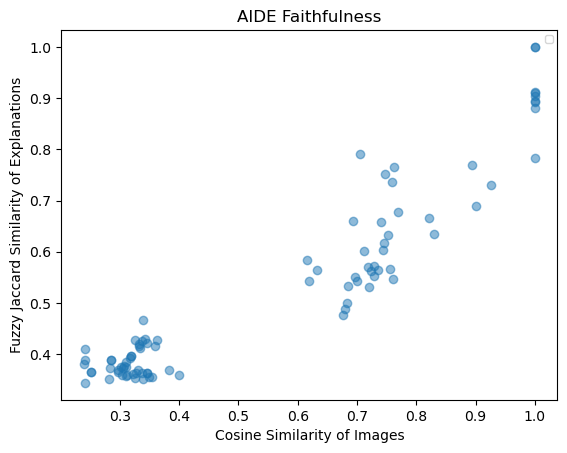

In [8]:
sample_idx = random.sample(range(0, X_test.shape[0]), 10)
cosine_total=[]
# jaccard_total=[]
# mbm_total=[]
fuzzy_total=[]
for i in tqdm(sample_idx):
    influences = module.influences(train_idxs=train_idxs, test_idxs=[i])
    if np.count_nonzero(influences)>800:        
        cosine_sim, fuzzy_jac = aide_eval(i)
        cosine_total.append(cosine_sim)
#         mbm_total.append(mbm_sim)
        #     mean_total.append(mean_ex_similarity)
#         jaccard_total.append(jac_sim)
        fuzzy_total.append(fuzzy_jac)
    else:
        continue

def flatten_sum(matrix):
    return sum(matrix, [])

# plt.figure()
# plt.scatter(flatten_sum(cosine_total), flatten_sum(mbm_total), alpha=0.5)
# plt.title("AIDE Faithfulness")
# plt.xlabel('Cosine Similarity of Images')
# plt.ylabel('Maximum Bipartite Matching Similarity of Explanations')
# plt.legend(fontsize=7)
# plt.savefig('aide_img_mbm22_vs_cos.eps', format='eps')
# plt.show()

plt.figure()
plt.scatter(flatten_sum(cosine_total), flatten_sum(fuzzy_total), alpha=0.5)
plt.title("AIDE Faithfulness")
plt.xlabel('Cosine Similarity of Images')
plt.ylabel('Fuzzy Jaccard Similarity of Explanations')
plt.legend(fontsize=7)
# plt.savefig('aide_img_jac22_vs_cos.eps', format='eps')
plt.show()


In [ ]:
        df = df_construct(3, train_idxs)
        df_pos_sl, df_pos_ol = input_data(df, i, Y_test, sett='positive')
        df_neg_ol, df_neg_sl = input_data(df, i, Y_test, sett='negative')
#         selected_indices_pos_sl = greedy_subset_selection(df_pos_sl, N=5, sett='positive', label='same')
#         selected_indices_pos_ol = greedy_subset_selection(df_pos_ol, N=5, sett='positive', label='opposite')
#         selected_indices_neg_sl = greedy_subset_selection(df_neg_sl, N=5, sett='negative', label='same')
#         selected_indices_neg_ol = greedy_subset_selection(df_neg_ol, N=5, sett='negative', label='opposite')
#         a=[df_pos_sl.Influence.index[k] for k in selected_indices_pos_sl]
#         b=[df_neg_ol.Influence.index[k] for k in selected_indices_neg_ol]
#         c=[df_neg_sl.Influence.index[k] for k in selected_indices_neg_sl]
#         d=[df_pos_ol.Influence.index[k] for k in selected_indices_pos_ol]

In [ ]:
df_neg_sl

In [ ]:
# Initialize the t-SNE algorithm
tsne = TSNE(n_components=2, random_state=42)

# Combine the training and test tensors
Y_test[300] = torch.tensor([1.])
Y_test[458] = torch.tensor([1.])
X = torch.cat((X_train, X_test), dim=0)
y = torch.cat((Y_train, Y_test), dim=0)

# Convert the tensors to numpy arrays
X = X.numpy()
y = y.numpy()

# Initialize the t-SNE algorithm
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the data to 2D
X_2d = tsne.fit_transform(X)

# Plot the data in 2D with different colors and alpha values for each class
plt.scatter(X_2d[y==0, 0], X_2d[y==0, 1], marker='o', c='#7FFFD4',  label='Dog', alpha=0.7)
plt.scatter(X_2d[y==1, 0], X_2d[y==1, 1], marker='o', c='#FFE5B4',  label='Fish', alpha=0.5)



plt.scatter([X_2d[df_pos_sl.index[i]][0] for i in selected_indices_pos_sl],
        [X_2d[df_pos_sl.index[i]][1] for i in selected_indices_pos_sl], marker='+', color='black', label='Support by Analogy')

plt.scatter([X_2d[df_pos_ol.index[i]][0] for i in selected_indices_pos_ol],
        [X_2d[df_pos_ol.index[i]][1] for i in selected_indices_pos_ol], marker='+', color='blue', label='Support by Contrast')

plt.scatter([X_2d[df_neg_sl.index[i]][0] for i in selected_indices_neg_sl],
        [X_2d[df_neg_sl.index[i]][1] for i in selected_indices_neg_sl], marker='x', color='blue', label='Oppose by Contrast')

plt.scatter([X_2d[df_neg_ol.index[i]][0] for i in selected_indices_neg_ol],
        [X_2d[df_neg_ol.index[i]][1] for i in selected_indices_neg_ol], marker='x', color='black', label='Oppose by Analogy')



# plt.scatter([X_2d[df_pos_ol.sort_values('Influence', ascending=False).index[i]][0] for i in range(6)],
#             [X_2d[df_pos_ol.sort_values('Influence', ascending=False).index[i]][1] for i in range(6)],
#             marker='x', color='blue', label='Influential Instances')

# plt.scatter([X_2d[df_pos_sl.sort_values('Relatif', ascending=False).index[i]][0] for i in range(6)],
#             [X_2d[df_pos_sl.sort_values('Relatif', ascending=False).index[i]][1] for i in range(6)],
#             marker='*', c='#FF00FF', label='Relatif Instances')

# plt.scatter([X_2d[df.sort_values('Influence', ascending=False).index[i]][0] for i in range(6)],
#             [X_2d[df.sort_values('Influence', ascending=False).index[i]][1] for i in range(6)],
#             marker='x', color='black', label='Influential Instances')

# plt.scatter([X_2d[df.sort_values('Influence', ascending=True).index[i]][0] for i in range(6)],
#             [X_2d[df.sort_values('Influence', ascending=True).index[i]][1] for i in range(6)],
#             marker='x', color='brown', label='Neg Influential Instances')

# plt.scatter([X_2d[len(Y_train)+i][0] for i in f],
#         [X_2d[len(Y_train)+i][1] for i in f], marker='x', color='yellow',alpha=0.5, label='Incorrect predictions')
plt.scatter(X_2d[len(Y_train)+test_idx][0], X_2d[len(Y_train)+test_idx][1], marker='.', color='red', label='Test Point')

plt.legend(fontsize=7)
plt.savefig(f'tsne_aide{test_idx}.pdf', format='pdf')
plt.show()


In [ ]:
fig, axs = plt.subplots(9, 5, figsize=(14, 14))
x=550
y=555
for k in range(x,y):
    axs[0,k-x].imshow(captioned_image(clf, embeds, 'test', k))
    axs[0, k-x].axis('off')
    axs[1,k-x].imshow(captioned_image(clf, embeds, 'test', k+5))
    axs[1, k-x].axis('off')
    axs[2,k-x].imshow(captioned_image(clf, embeds, 'test', k+10))
    axs[2, k-x].axis('off')
    axs[3,k-x].imshow(captioned_image(clf, embeds, 'test', k+15))
    axs[3, k-x].axis('off')
    axs[4,k-x].imshow(captioned_image(clf, embeds, 'test', k+20))
    axs[4, k-x].axis('off')
    axs[5,k-x].imshow(captioned_image(clf, embeds, 'test', k+25))
    axs[5, k-x].axis('off')
    axs[6,k-x].imshow(captioned_image(clf, embeds, 'test', k+30))
    axs[6, k-x].axis('off')
    axs[7,k-x].imshow(captioned_image(clf, embeds, 'test', k+35))
    axs[7, k-x].axis('off')
    axs[8,k-x].imshow(captioned_image(clf, embeds, 'test', k+40))
    axs[8, k-x].axis('off')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 100 random values between 0 and 1 for correlation
random_values = np.sort(np.random.rand(250))

# Generate Jaccard similarity values
jaccard_similarities = random_values
jaccard_similarities[3:12]=0
jaccard_similarities[17:24]=0
jaccard_similarities[14]=0
jaccard_similarities[27:29]=0
jaccard_similarities[32:35]=0
jaccard_similarities[:50]=jaccard_similarities[:50]/1.7-0.01
jaccard_similarities[50:]=jaccard_similarities[50:]/1.4+0.1
jaccard_similarities[50:54]=jaccard_similarities[50:54]-0.01
# Generate cosine similarity values
cosine_similarities = random_values+np.random.rand(250)/6+0.07
cosine_similarities[20:50]=cosine_similarities[20:50]-0.05
cosine_similarities[50:70]=cosine_similarities[50:70]+0.07
cosine_similarities[50:70]=cosine_similarities[50:70]+0.07
cosine_similarities[50:60]=cosine_similarities[50:60]+0.1
cosine_similarities[-5:]=1
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(cosine_similarities, jaccard_similarities,  color='blue', alpha=0.7)
plt.title("Cosine Similarity vs Jaccard")
plt.xlabel("Cosine Similarity")
plt.ylabel("Jaccard Similarity")
plt.show()


In [ ]:
jaccard_similarities